**Goal:** Show that the cloning circuit developed in the notes is phase-covariant on equatorial qubits.

**Remark on Gates.** I think we can obtain all of the equatorial qubits using the $U$-gate in Qiskit. In particular, all of the equatorial qubits are obtained by $U(\pi/2,0, \lambda)$ where we allow $\lambda \in [0, 2\pi]$. To test whether the cloning circuit is phase covariant on equatorial qubits we will use a gate of this form to move to the equator, clone the equatorial qubit, and then invert the unitary to get back to a state that is perturbed slightly from $\vert 0 \rangle$. A measurement will then reveal how successful we have been in cloning. (This is analogous to applying the Hadamard gate, the cloning circuit, and the Hadamard gate before measuring; the Hadamard gate is its own inverse.)

In [1]:
# from qiskit import *
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex

# numpy for linear algebra stuff
from numpy.random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt

# To supress the deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
#%run utility_functions.ipynb

In [2]:
def Theta2(theta1):
    if theta1 <= np.pi/4:
        theta2 = 0.5 * np.arccos(np.cos(2*theta1)/np.sin(2*theta1))
    if theta1 > np.pi/4:
        theta2 = 0.5 * np.arccos(-np.cos(2*theta1)/np.sin(2*theta1))
    
    return theta2

In [3]:
def theta_maker(theta1):
    if (theta1 == np.pi/8) or (theta1 == 3*np.pi/8):
        theta2 = 0
        theta3 = 0
        return np.array([theta1, theta2, theta3])
    
    
    etaA = np.sin(2 * theta1)
    theta2 = Theta2(theta1)
    theta3 = np.arctan(np.tan(theta1) * np.tan(theta2))
    theta = np.array([theta1, theta2, theta3])
    return theta

In [4]:
# this is a function that implements the cloning that Eve uses
def EveClones(qc, theta1):
    # determine optimizing angles
    theta = theta_maker(theta1)
    
    # prepare to clone 
    qc.u(2*theta[0], 0, 0, 1)
    qc.cx(1,2)
    qc.u(2*theta[1], 0, 0, 2)
    qc.cx(2,1)
    qc.u(2*theta[2], 0, 0, 1)
    
    # execute the cloning component with the input qubit (the 0 qubit here)
    qc.cx(0,1)
    qc.cx(0,2)
    qc.cx(1,0)
    qc.cx(2,0)
    
    qc.barrier()
    
    return qc

In [5]:
def Phase_Measurements(lam, theta1):
    qc = QuantumCircuit(3,2)
    
    # prepare the 0-qubit
    qc.u(np.pi/2, 0, lam, 0)
    #qc.h(0)
    
    qc.barrier()

    # Eve prepares her clones
    EveClones(qc,theta1)

    
    qc.u(-np.pi/2, -lam, 0, 0)
    qc.measure(0,0)
    qc.barrier()

    qc.u(-np.pi/2, -lam, 0, 1)
    qc.measure(1,1)

    shots = 10000 # number of samples used for statistics
    sim = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend = sim, shots = shots)
    
    out00 = job.result().get_counts().get("00")
    out01 = job.result().get_counts().get("01")
    out10 = job.result().get_counts().get("10")
    out11 = job.result().get_counts().get("11")
    
    if out00 == None:
        out00 = 0
    if out01 == None:
        out01 = 0
    if out10 == None:
        out10 = 0
    if out11 == None:
        out11 = 0
        
    Fid_Bob = (out00 + out10)/shots
    Fid_Eve = (out00 + out01)/shots
    
    return Fid_Bob, Fid_Eve

**Small Test.** We begin with a test that includes to angles $\lambda$, just to see that the results are comparable. Here we use $\theta_{1} = \frac{\pi}{4} - 0.1$.

In [6]:
F_bob, F_eve = Phase_Measurements(0, np.pi/4 - 0.1)

In [7]:
print(F_bob, F_eve)

0.9876 0.5984


In [8]:
Q_b, Q_e = Phase_Measurements(np.pi/2, np.pi/4 - 0.1)
print(Q_b, Q_e)

0.9911 0.6058


**A More General Test.** We consider a selection of equatorial qubits, measure the fidelity of the clone for both Bob and Eve, and expect to see lines that are (roughly) horizontal.

In [9]:
L = np.linspace(0, 2*np.pi, 100)
B = np.zeros(len(L))
E = np.zeros(len(L))

for j in range(len(L)):
    B[j], E[j] = Phase_Measurements(L[j], np.pi/4 - 0.1)


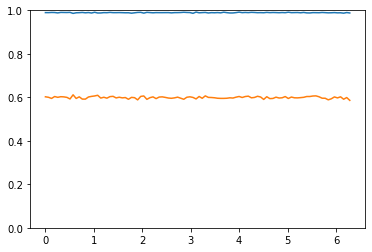

In [10]:
plt.figure()
plt.plot(L,B)
plt.plot(L,E)
plt.ylim([0,1])
plt.show()

**Fidelity Calculations.** Here we consider the fidelity that is predicted in the notes with what we find in the experiments using the Qiskit simulators. These experiments do not involve more than one equatorial qubit at a time. Rather, we are interested in the fidelity we obtain when we vary the angle $\theta_{1}$ in the cloning circuit.

In [11]:
T = np.linspace(np.pi/8 + 0.01, 3*np.pi/8 - 0.01, 100)
BT = np.zeros(len(T))
ET = np.zeros(len(T))

for j in range(len(T)):
    BT[j], ET[j] = Phase_Measurements(np.pi/2, T[j])
    
BobFid = 0.5 * (1 + np.sin(2*T))
EveFid = 0.5 * (1 + np.abs(np.cos(2 * T)))

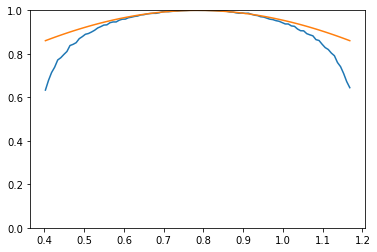

In [12]:
plt.figure()
plt.plot(T,BT)
plt.plot(T,BobFid)
plt.ylim([0,1])
plt.show()

The preceding plot shows two curves: the blue curve is Bob's actual QBER as we vary the value of $\theta_{1}$, while the orange curve is the theoretical prediction. The two curves are close near the maximum (at $\theta_{1} = np.pi/4$) but there's a deviation closer to the endpoint values. Why?

**Fidelity Calculation for Eve.** We have chosen $\theta_{2}$ to optimize Eve's fidelity. Recall that Eve's fidelity is $F_{E} = \frac{1}{2}(1 + \eta_{E})$ and $\eta_{E} = \sin(2\theta_{1}) \cos(2 \theta_{2})$. We've selected
$$
\theta_{2} = \frac{1}{2} \arccos ( \cot(2 \theta_{1})).
$$
This means that
$$
\eta_{E} = \sin(2 \theta_{1}) \cot(2 \theta_{1}) = \cos(2 \theta_{1}).
$$
It's important to remember that the factor $\eta_{E}$ is nonnegative, meaning that we should actually consider $\eta_{E} = \vert \cos(2 \theta_{1}) \vert$.

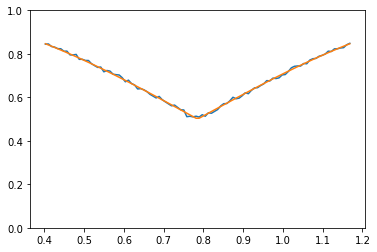

In [13]:
plt.figure()
plt.plot(T,ET)
plt.plot(T,EveFid)
plt.ylim([0,1])
plt.show()

**Summary.** The fidelity obtained for Bob differs slightly from what we find in the experiments. The predicted fidelity for Eve seems to be very good.

In [14]:
BobEta = 2*BT - 1
EveEta = np.sqrt(1 - BobEta**2)
FidEveEta = 0.5 * (1 + EveEta)

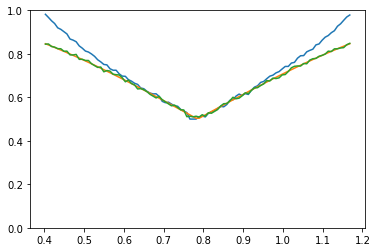

In [15]:
plt.figure()
plt.plot(T,FidEveEta)
plt.plot(T, EveFid)
plt.plot(T, ET)
plt.ylim([0,1])
plt.show()

This graph actually shows three curves. What appears to be green is the overlap between the theoretical prediction for Eve and the one that we observe directly from the circuit. The blue curve is what we expect based on Bob's results from the circuit. We see that there is a discrepancy again.